In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from IPython.display import display

%matplotlib inline

Using Theano backend.


In [2]:
# updating the path to use the ml_helpers
import sys
sys.path.append('/Users/jonbruno/Documents/Python/Kaggle')
# display(sys.path)

In [3]:
# fix random seed for reproducability
seed = 0
np.random.seed(seed)

### Load the Desired Features

In [4]:
# create the engineered featureset
import feature_eng

# import the raw data
path = '/Users/jonbruno/Documents/Python/Kaggle/Housing/data/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

# the latest feature set
train, test = feature_eng.feature_eng_02(train,test)

In [5]:
# select the data required for the model
X = train.drop(['Id','SalePrice'],axis=1)
y = train.SalePrice

X_test = test.drop(['Id'],axis=1)

#### Benchmark our Features

In [6]:
# benchmark our features
from ml_helpers import feature_importance as fi

lin_clf,lasso_clf,rf_clf = fi.feature_importance_regression(X,y,15)

/Users/jonbruno/anaconda/envs/housing/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonbruno/anaconda/envs/housing/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonbruno/anaconda/envs/housing/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Description:	Linear Regression coefficients.
Be sure to check for multicolinearity i.e. examine both the head and tail of the coefficients

RMSE mean and std:	0.137 +/- 0.016
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

14 features exlcuded
192 features remaining

The top 15 features:

    index      coef               feature
0      56   208.711              TotFinSF
1      59   208.154         PorchSF_Ratio
2      57  0.475237   LvgSpaceAbvGr_Ratio
3     187   0.37243      RoofMatl_WdShngl
4     182  0.328048      RoofMatl_Membran
5     183  0.318542        RoofMatl_Metal
6      88  0.306755       Condition2_PosA
7     193    0.1956        RoofStyle_Shed
8     181  0.187215      RoofMatl_CompShg
9     111  0.187159     HouseStyle_1.5Unf
10     92  0.153219       Condition2_RRNn
11    186  0.122371      RoofMatl_WdShake
12    174  0.120649  Neighborhood_StoneBr
13    184  0.117932         RoofMatl_Roll
14    185  0.113389      RoofMatl_Tar&Grv
Descript

#### Additional Feature Eng...

In [8]:
# lets see the intersection of the included features from Lasso and Random Forest
a = set(lasso_clf.inlcuded_features['feature'])
b = set(rf_clf.inlcuded_features['feature'])

common_features = list(a.intersection(b))

In [ ]:
# what if we try to select polynomial features from the common_features
# once upon a time - ghouls??? - i wrote a function to name the polynomial feature columns
# we should bring that back

## Benchmark Neuron

In [9]:
# create a baseline MLP
def benchmark():
    # create model
    model = Sequential()
    model.add(Dense(300,input_dim=X.shape[1],init='uniform',activation='relu'))
    model.add(Dense(200, input_dim=300, init='uniform', activation='relu'))
    model.add(Dense(100, input_dim=200, init='uniform', activation='relu'))
    model.add(Dense(50, input_dim=100, init='uniform', activation='relu'))
    model.add(Dense(1, init='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model



In [10]:
pipe_mlp = Pipeline([('scl', MinMaxScaler() ),
                     ('mlp', KerasRegressor(build_fn=benchmark,
                                            nb_epoch=300,
                                            batch_size=50,
                                            verbose=0) )])

In [11]:
kfold = KFold(n_splits=5, random_state=seed)

<module 'matplotlib.pyplot' from '/Users/jonbruno/anaconda/envs/housing/lib/python3.5/site-packages/matplotlib/pyplot.py'>

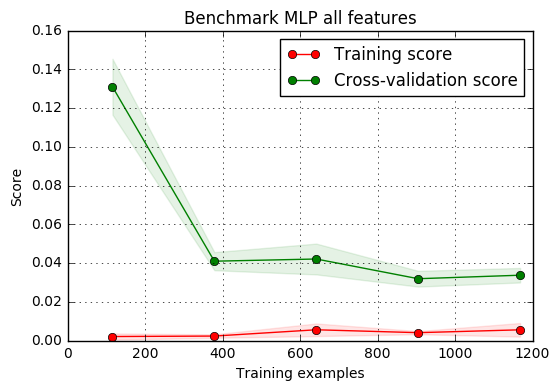

In [12]:
# model validation curve
from ml_helpers.model_eval import plot_learning_curve

plot_learning_curve(estimator=pipe_mlp,
                    title="Benchmark MLP all features",
                    X=X,y=y,cv=kfold)

In [20]:
X[common_features].shape

(1460, 60)

## MLP with dropout 

- http://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
- http://blog.mrtanke.com/2016/10/09/Keras-Study-Notes-3-Dropout-Regularization-for-Deep-Networks/
- https://statcompute.wordpress.com/2017/01/02/dropout-regularization-in-deep-neural-networks/

In [28]:
from keras.layers import Dropout
from keras.constraints import maxnorm

### Dropout at the Input Layer

In [51]:
# best guess at an input layer dropout model - little tuning or understanding - based on machinelearningmastry
def dropout_input():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(X.shape[1],)))
    model.add(Dense(300, input_dim=X.shape[1], init='uniform',activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(200, input_dim=300, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(100, input_dim=200, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(50, input_dim=100, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(1, init='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

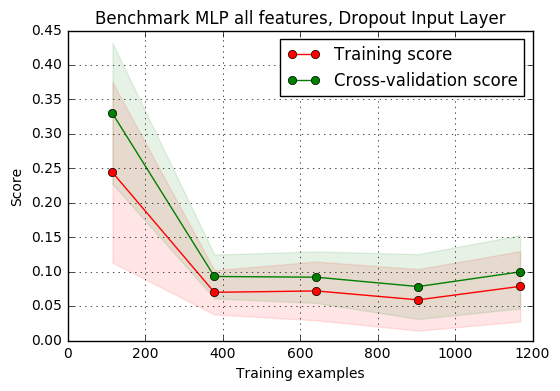

In [52]:
pipe_mlp_drop_in = Pipeline([('scl', MinMaxScaler() ),
                     ('mlp', KerasRegressor(build_fn=dropout_input,
                                            nb_epoch=300,
                                            batch_size=50,
                                            verbose=0) )])

mlp_drop_in_all = plot_learning_curve(estimator=pipe_mlp_drop_in,
                    title="Benchmark MLP all features, Dropout Input Layer",
                    X=X,y=y,cv=kfold)

### Dropout of Hidden Layers

In [32]:
# best guess at a hidden layer dropout model - little tuning or understanding - based on machinelearningmastry
def dropout_hidden():
    # create model
    model = Sequential()
    model.add(Dense(300,input_dim=X.shape[1],init='uniform',activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(200, input_dim=300, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(100, input_dim=200, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(50, input_dim=100, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(1, init='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

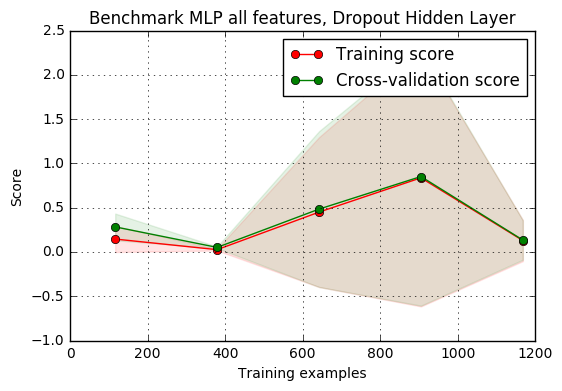

In [33]:
pipe_mlp_drop_hid = Pipeline([('scl', MinMaxScaler() ),
                     ('mlp', KerasRegressor(build_fn=dropout_hidden,
                                            nb_epoch=300,
                                            batch_size=50,
                                            verbose=0) )])

mlp_drop_hid_all = plot_learning_curve(estimator=pipe_mlp_drop_hid,
                    title="Benchmark MLP all features, Dropout Hidden Layer",
                    X=X,y=y,cv=kfold)

# Using the Selected Features 
i.e. the features common to Lasso and RandomForest

### Benchmark with Selected Features

In [35]:
# create a baseline MLP
def benchmark2():
    # create model
    model = Sequential()
    model.add(Dense(300,input_dim=X[common_features].shape[1],init='uniform',activation='relu'))
    model.add(Dense(200, input_dim=300, init='uniform', activation='relu'))
    model.add(Dense(100, input_dim=200, init='uniform', activation='relu'))
    model.add(Dense(50, input_dim=100, init='uniform', activation='relu'))
    model.add(Dense(1, init='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

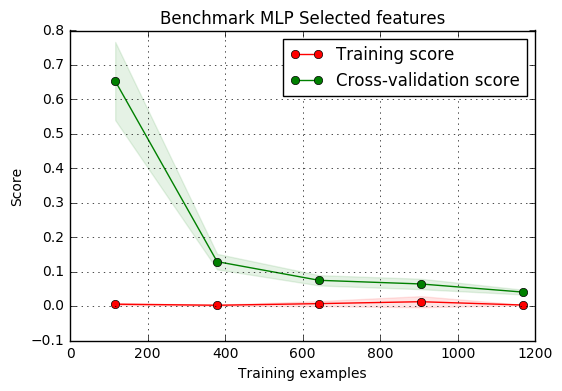

In [36]:
# plot only the "best" features
pipe_mlp_best = Pipeline([('scl', MinMaxScaler() ),
                     ('mlp', KerasRegressor(build_fn=benchmark2,
                                            nb_epoch=300,
                                            batch_size=50,
                                            verbose=0) )])


mlp_benchmark = plot_learning_curve(estimator=pipe_mlp_best,
                    title="Benchmark MLP Selected features",
                    X=X[common_features],y=y,cv=kfold)

### Droput at Input Layer Selected Features

In [54]:
# best guess at an input layer dropout model - little tuning or understanding - based on machinelearningmastry
def dropout_input2():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(X[common_features].shape[1],)))
    model.add(Dense(300,input_dim=X.shape[1],init='uniform',activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(200, input_dim=300, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(100, input_dim=200, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(50, input_dim=100, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(1, init='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

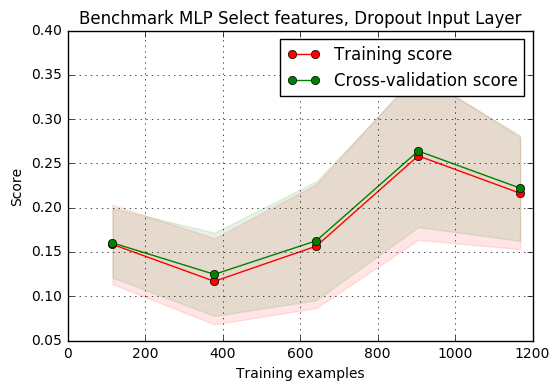

In [55]:
# only the "Best" features
pipe_mlp_drop_in = Pipeline([('scl', MinMaxScaler() ),
                     ('mlp', KerasRegressor(build_fn=dropout_input2,
                                            nb_epoch=300,
                                            batch_size=50,
                                            verbose=0) )])

mlp_drop_in_best = plot_learning_curve(estimator=pipe_mlp_drop_in,
                    title="Benchmark MLP Select features, Dropout Input Layer",
                    X=X[common_features],y=y,cv=kfold)

### Dropout at Hidden Layers Selected Features

In [37]:
# best guess at a hidden layer dropout model - little tuning or understanding - based on machinelearningmastry
def dropout_hidden2():
    # create model
    model = Sequential()
    model.add(Dense(300,input_dim=X[common_features].shape[1],init='uniform',activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(200, input_dim=300, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(100, input_dim=200, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(50, input_dim=100, init='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(1, init='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

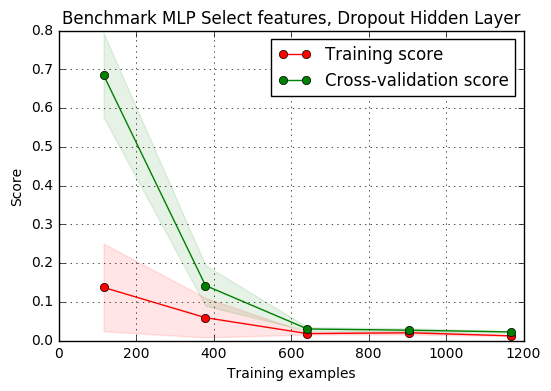

In [39]:
# only the "Best features"
pipe_mlp_drop_hid2 = Pipeline([('scl', MinMaxScaler() ),
                     ('mlp', KerasRegressor(build_fn=dropout_hidden2,
                                            nb_epoch=300,
                                            batch_size=50,
                                            verbose=0) )])

mlp_drop_hid_best = plot_learning_curve(estimator=pipe_mlp_drop_hid2,
                    title="Benchmark MLP Select features, Dropout Hidden Layer",
                    X=X[common_features],y=y,cv=kfold)

### Fitting the model and creating a submission

In [58]:
# train the best model
pipe_mlp_drop_hid2.fit(X[common_features],y)

Pipeline(steps=[('scl', MinMaxScaler(copy=True, feature_range=(0, 1))), ('mlp', <keras.wrappers.scikit_learn.KerasRegressor object at 0x11aa3bd30>)])

In [60]:
# to get the final SalePrice we need to convert back from log + 1
pred = np.expm1(pipe_mlp_drop_hid2.predict(X_test[common_features]))
display(pred)

array([ 130311.7734375,  146758.171875 ,  187149.875    , ...,
        144068.453125 ,  113590.1484375,  223929.46875  ], dtype=float32)

In [65]:
submission = pd.DataFrame({'Id':test.Id,'SalePrice':pred})
submission.head()

,Id,SalePrice
0,1461,130311.773438
1,1462,146758.171875
2,1463,187149.875000
3,1464,198695.625000
4,1465,185422.875000


In [66]:
# submission.to_csv('mlp_drop_best_features.csv',index=False)